### Introducción
El objetivo final de este proyecto es predecir el sentimiento de un texto dado usando python, donde usamos NLTK, también conocido como Natural Language Processing Toolkit y de ser posible precisar el impacto causado por los comentarios positivos y negativos sobre un determinado comportamiento.

* Para este proyecto, importaremos un conjunto de librerías que se muestran a continuación
* Importaremos el conjunto de datos
* Realizaremos limpieza, formateo y visualización de los datos
* Construcción del modelo
* Predicción
* Medición de impacto 

In [72]:
# Importar librerías
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [61]:
import string as st

In [63]:
print(nltk.data.path)

['C:\\Users\\Joako/nltk_data', 'c:\\Users\\Joako\\anaconda3\\envs\\ReviewProject\\nltk_data', 'c:\\Users\\Joako\\anaconda3\\envs\\ReviewProject\\share\\nltk_data', 'c:\\Users\\Joako\\anaconda3\\envs\\ReviewProject\\lib\\nltk_data', 'C:\\Users\\Joako\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [68]:
nltk.download('stopwords')
nltk.data.path.append('c:\\Users\\Joako\\anaconda3\\envs\\ReviewProject\\nltk_data')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joako\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joako\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Importar datos
data = pd.read_csv('C:\\Users\\Joako\\Documents\\AnalisisDatos\\ReviewProject\\DatosOriginales\\reviews_filmaffinity.csv', delimiter='|', header=0)

In [5]:
data.shape

(8591, 6)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8591 entries, 0 to 8590
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8591 non-null   object 
 1   gender         8591 non-null   object 
 2   film_avg_rate  8591 non-null   object 
 3   review_rate    8589 non-null   float64
 4   review_title   8591 non-null   object 
 5   review_text    8591 non-null   object 
dtypes: float64(1), object(5)
memory usage: 402.8+ KB


In [7]:
data.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m..."
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll..."
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"Pero cuando amanece,y me quedo solo,siento en ..."


In [8]:
# Encontrar nulos
data.isnull().sum()

film_name        0
gender           0
film_avg_rate    0
review_rate      2
review_title     0
review_text      0
dtype: int64

In [9]:
# Eliminar nulos
data=data.dropna()

In [10]:
# Comprobando datos de la columna y noto que los valores contienen una coma y además son objetos. 
film=data['film_avg_rate'].unique()
print(film)


['6,0' '6,8' '4,4' '6,7' '4,8' '5,3' '6,5' '6,4' '7,2' '4,2' '6,9' '3,7'
 '5,7' '5,5' '7,7' '6,1' '5,8' '5,2' '5,4' '4,6' '5,0' '7,1' '3,9' '4,7'
 '5,1' '6,2' '6,6' '7,0']


In [11]:
# La columna film_avg_rate La convierto en float y remplazo ',' por '.'
data['film_avg_rate'] = data['film_avg_rate'].str.replace(',', '.').astype(float)


In [12]:
# comprobar rango de puntajes en la columna review_rate
rate=data['review_rate'].unique()
print(rate)

[ 3.  2.  8.  1.  6.  4.  5.  7.  9. 10.]


In [13]:
data.describe()

,film_avg_rate,review_rate
count,8589.000000,8589.000000
mean,6.186972,5.872744
std,0.991661,2.549188
min,3.700000,1.000000
25%,5.500000,4.000000
50%,6.500000,6.000000
75%,6.900000,8.000000
max,7.700000,10.000000


Crear una escala más manejable de los valores de review_rate en el que agruparemos siguiendo el criterio de normalidad que nos muestra la descripción de la tabla el 25 % de los puntajes estan entre 1-4, con lo cual los agrupamos con el puntaje 0 = 1,2,3,4 y los significamos como valores negativos. entre el 25% y el 75% se ubican los puntajes entre  5-8 y los agrupamos con el puntaje 1 = 5,6,7, significandolos neutrales y por encima del 75% los puntajes 9,10 que agrupamos en el puntaje 2 = 8,9,10 como positivos.

In [14]:
# Valoración calificaciones 

def clasificar_rate(n_review):
    if (n_review <= 4.0).all():
        return 'Negative'
    elif ((n_review > 4.0) & (n_review <= 7.0)).any():
        return 'Neutral'
    else:
        return 'Positive'
    
data['value_rate']= data.groupby(level=0)['review_rate'].apply(lambda x: clasificar_rate(x))

In [15]:
data.sample(5)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,value_rate
5037,Mientras dure la guerra,Drama,6.8,8.0,Las dos Españas en unos personajes históricos ...,Amenábar ofrece el reflejo de la cristalina di...,Positive
5907,Tres metros sobre el cielo,Romance,4.7,8.0,Se puede profundizar un poco más y te das cuen...,"Para mí es una buena película, es entretenida,...",Positive
1007,Ocho apellidos catalanes,Comedia,4.4,6.0,"Menos graciosa que la anterior, pero entretenida",No entiendo lo enconadas de algunas críticas a...,Neutral
8484,La isla mínima,Cine negro,7.2,8.0,Un thriller que hará que no te levantes del si...,"He de comentar que la película la adquirí en ""...",Positive
1807,Ágora,Aventuras,6.5,7.0,El tránsito desde ser Amenábar hasta ser Spiel...,"Amenábar siempre ha querido ser Spielberg, sie...",Neutral


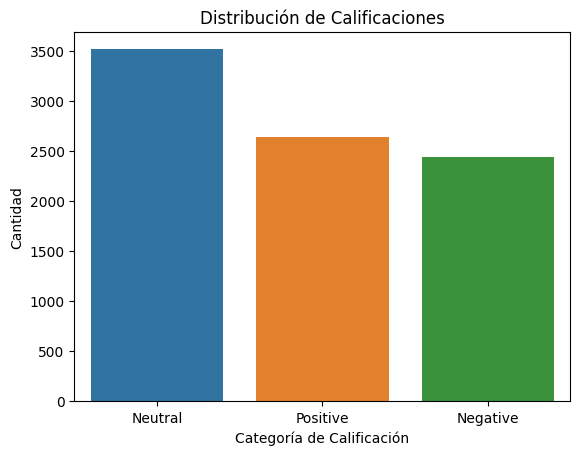

In [16]:
# Obtener la frecuencia de cada categoría
category_counts = data['value_rate'].value_counts()

# Crear el gráfico de barras
sns.barplot(x=category_counts.index, y=category_counts.values)

# Configurar los ejes y el título del gráfico
plt.xlabel('Categoría de Calificación')
plt.ylabel('Cantidad')
plt.title('Distribución de Calificaciones')

# Mostrar gráfico
plt.show()

In [18]:
#Simplificación de sentimientos
a=[]
for i, review_rate in enumerate(data['review_rate']):
    if review_rate <= 4.0:
        a.append(0)
    elif review_rate <= 7.0:
        a.append(1)
    elif review_rate > 7.0:
        a.append(2)
    else:
        print(f"Unmatched value at index {i}: {review_rate}")


        

In [19]:
a = [int(value) for value in a]

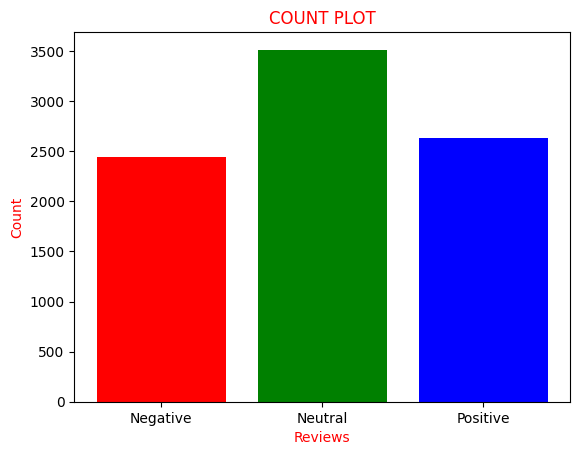

In [20]:
#Graficamos solo con matplotlib.pyplot porque seaborn esta dando un error

# Contar la frecuencia de cada categoría en 'a'
counts = [a.count(0), a.count(1), a.count(2)]

# Etiquetas de las categorías
labels = ['Negative', 'Neutral', 'Positive']

# Colores para las barras
colors = ['red', 'green', 'blue']

# Crear el gráfico de barras con colores diferentes
plt.bar(labels, counts, color=colors)
plt.xlabel('Reviews', color="red")
plt.ylabel('Count', color="red")
plt.title('COUNT PLOT', color="r")
plt.show()

In [21]:
data['sentiment']=a
final_dataset = data[['review_text', 'sentiment']]
print(final_dataset)

                                            review_text  sentiment
0     La mayor virtud de esta película es su existen...          0
1     No soy un experto cinéfilo, pero pocas veces m...          0
2     Si no eres un incondicional del humor estilo T...          0
3     No sé qué está pasando, si la gente se deja ll...          0
4     Pero cuando amanece,y me quedo solo,siento en ...          0
...                                                 ...        ...
8586  Buena no, lo siguiente. Por fin un film serio ...          2
8587  Me esperaba mucho, pero que mucho, más.Guión m...          0
8588  De mal cuerpo como sensación al finalizar, de ...          0
8589  Los que han añadido comentarios os lo han dich...          0
8590  Fui a ver esta película de cine con entusiasmo...          0

[8589 rows x 2 columns]


In [22]:
#Cuento cantidad de comentarios

data_p=final_dataset[data['sentiment']==2]
data_n=final_dataset[data['sentiment']==0]
len(data_n), len(data_p)

(2440, 2635)

In [23]:
#Selecciono la misma cantidad de comentarios positivos y negativos

datap = data_p.iloc[np.random.randint(0, len(data_p), 2400), :]
datan = data_n.iloc[np.random.randint(0, len(data_n), 2400), :]

len(datan), len(datap)

(2400, 2400)

In [24]:
# creo nuevo dataset con datos equivalentes para el modelo

data_sent = pd.concat([datap,datan])
len(data_sent)

4800

In [26]:
data_sent.sample()

,review_text,sentiment
2014,En la primera (Y en mi opinión mejor) película...,0


In [27]:
# En una nueva variable asigno 0 a los valores negativos y 1 a los valores positivos.
c=[]
for i in data_sent['sentiment']:
    if i==2:
        c.append(1)
    if i==0:
        c.append(0)
data_sent['sentiment']=c

In [48]:
data_sent.sample(10)

,review_text,sentiment
4750,"Comedia alocada, gamberra y disparatada, que m...",1
3107,"Me obligaron (y cuando digo obligaron, es que ...",0
8122,"Vamos destrozando canciones, por Dios que desa...",0
6655,"Bueno, es evidente que cuando le hacen un golp...",1
3223,Ante las malas críticas que he estado observan...,1
7546,"Si no tenemos en cuenta ""El proyecto de la bru...",0
783,Cuando los eventos superan las expectativas de...,1
4551,Aquí tenemos la continuación de la historia de...,0
6838,Alguien nos había dicho que esta era una pelíc...,0
5033,"Otra vez Los Otros, pero esta vez no son habit...",1


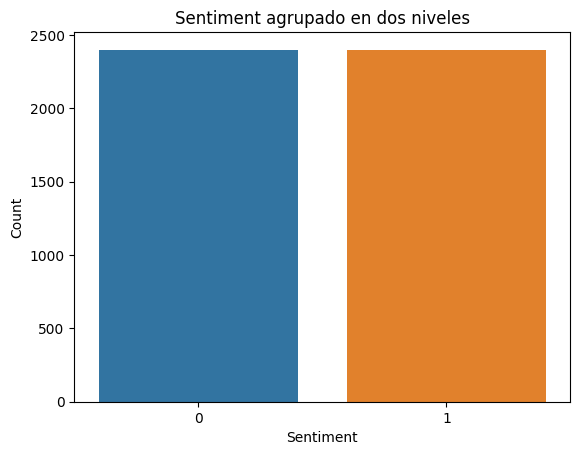

In [47]:
# Visualizar
sns.countplot(data=data_sent, x='sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment agrupado en dos niveles')
plt.show()

## Construcción del modelo

In [52]:
data_sent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4800 entries, 221 to 4355
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  4800 non-null   object
 1   sentiment    4800 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 241.5+ KB


In [55]:
# Eliminar signos
def punc_clean(text):
    punctuation = ''.join([c for c in st.punctuation if c != '´'])
    a = [w for w in text if w not in punctuation]
    return ''.join(a)

data_sent['review_text'] = data_sent['review_text'].apply(punc_clean)


In [56]:
data_sent.head()

,review_text,sentiment
221,Varios motivos por la que esta película saca u...,1
6779,La verdad es que me fui sorprendido del cine p...,1
6734,Yo no soy ningún fan de Guillermo del Toro es ...,1
3987,La mejor película que ha dado el cine español ...,1
3450,Siento disentir con todos pero a mí la películ...,1


In [70]:
# Eliminar palabras vacías
def remove_stopwords(text):
    stopword=nltk.corpus.stopwords.words('spanish')
    stopword.remove('no')
    a=[w for w in nltk.wordpunct_tokenize(text) if w not in stopword]
    return ' '.join(a)
data_sent['review_text'] = data_sent['review_text'].apply(remove_stopwords)

In [71]:
data_sent.head()

,review_text,sentiment
221,Varios motivos película saca notable Porque pr...,1
6779,La verdad sorprendido cine sorpresa llena imag...,1
6734,Yo no ningún fan Guillermo Toro películas pare...,1
3987,La mejor película dado cine español últimos añ...,1
3450,Siento disentir película encantado Recreaestup...,1


In [73]:
# asignar palabra de texto con sentimientos 

vectr = TfidfVectorizer(ngram_range=(1,2),min_df=1)
vectr.fit(data_sent['review_text'])

vect_X = vectr.transform(data_sent['review_text'])

In [78]:
# construir modelo de regresión lineal simple
model = LogisticRegression()
clf=model.fit(vect_X,data_sent['sentiment'])

In [79]:
# Probar modelo
clf.predict(vectr.transform(['Amo el helado de chocolate con crema']))

array([0], dtype=int64)

In [80]:
clf.predict(vectr.transform(['Destesto las pelis comicas']))

array([1], dtype=int64)

In [81]:
clf.predict(vectr.transform(['No existen peliculas cómicas que sean buenas, todas son un fraude']))

array([0], dtype=int64)

In [82]:
clf.predict(vectr.transform(['Que perdida de tiempo con esta peli, dos horas tiradas a la basura']))

array([0], dtype=int64)

In [83]:
# Evaluar precisión del modelo

accuracy = model.score(vect_X, data_sent['sentiment']) * 100
print('Precisión: {:.2f}%'.format(accuracy))

Precisión: 99.12%


In [84]:
clf.predict(vectr.transform(['Sus trabajos me facinan siempre logra enganchar con su guión']))

array([1], dtype=int64)

In [89]:


clf.predict(vectr.transform(['Quiero cambiar los enlaces de teclas porque los valores predeterminados son culo']))

array([0], dtype=int64)

In [91]:
clf.predict(vectr.transform(['Algo que me molestó mucho del primero es el corte que hacen en la historia del primer juego para la batalla final , te quedabas con muchas dudas de la historia, este juego mejora bastante en la historia resolviendo varias dudas que me dejó el primer juego, volviendo a ver personajes muy buenos de la primera parte, la historia es buena pero el final lo dejan como para la tercera parte pero se siente bien, la música está bien, la jugabilidad y las nuevas criaturas mecánicas le dan un aire fresco , también las misiones me gustaron bastante. Lo malo algunos bugs visuales y algunos fallos en el juego que hacen que la play se apagará/congelará en su lanzamiento, luego lo arreglaron.']))

array([1], dtype=int64)

Para analisis de contenido

In [92]:
final_dataset.review_text[0]

'La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales razones por la que los españoles hemos acudido en masa, en una masa casi sin precedentes, a los cines a ver este producto patrocinado por Tele 5. Esa junto con 

In [93]:
final_dataset.review_text[1]

'No soy un experto cinéfilo, pero pocas veces me había sentido tan fuera de juego en una sala de cine: un auténtico perro verde. Leyendo las críticas en Filmaffinity, esta sensación se acrecienta, y voy cogiendo tonos atornasolados. La película no me gustó (con la honrosa excepción de alguna situación francamente buena): las bromas oscilaban entre "muy fáciles" y "todavía más fáciles" y la sobreactuación caricaturesca de los actores me exasperaba; esforzándome por contagiarme de las constantes risas que me rodeaban y de aquella señora de la última fila que disfrutaba de la película de su vida... pero fui incapaz.O me hago mayor y se me está agriando el carácter y no tengo el buen humor del que solía fanfarronear o... ¡hay algo que se me escapa!.Justo después de terminar de ver Breaking Bad (nada que ver en cuanto a género, por supuesto) me enfrento a este engendro y se me cae el alma a los pies... pero el tema empeora después de leer algunas críticas en las que se ensalza la frescura d

In [94]:
final_dataset.review_text[2]

'Si no eres un incondicional del humor estilo Tele 5.Si no terminas de captar de qué se ríen los adolescentes granulentos de tu familia.Si eres más de David Navarro que de Dani Rovira.Si lo de "Euskadi tiene un color especial" no te parece el hallazgo del siglo.Si con el Risitas y el Peíto has sentido alguna vez vergüenza ajena.Si te da repelús que algunos alaben esta película por su "valentía".Si no crees que haya que ser una Juana de Arco para explotar topicazos.Si "Bienvenidos al Norte" te pareció una puta chorrada.Si te importa un huevo que te digan que no tienes sentido del humor.Si Emilio Martínez-Lázaro te parece un director-despojo.Si te avergüenzan los índices de audiencia de la televisión de este país.Si no acostumbras a comer mierda.... No te comas esta mierda.'

In [96]:
data.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,value_rate,sentiment
0,Ocho apellidos vascos,Comedia,6.0,3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...,Negative,0
1,Ocho apellidos vascos,Comedia,6.0,2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m...",Negative,0
2,Ocho apellidos vascos,Comedia,6.0,2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...,Negative,0
3,Ocho apellidos vascos,Comedia,6.0,2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll...",Negative,0
4,Ocho apellidos vascos,Comedia,6.0,2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"Pero cuando amanece,y me quedo solo,siento en ...",Negative,0


In [97]:
data.review_rate[0]

3.0

In [98]:
data.review_rate[1]

2.0

In [99]:
data.review_rate[2]

2.0

In [105]:
data.sample(10)

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,value_rate,sentiment
2231,Perfectos desconocidos,Comedia,6.4,9.0,"Excelente ,","Excelente,entretenida,amena,divertida.Te engan...",Positive,2
8011,El bola,Drama,7.0,9.0,Una de las tres mejores películas españolas de...,"El bola es un film modesto, pues no tiene ínfu...",Positive,2
6454,El laberinto del fauno,Fantástico,7.2,8.0,Magnífico laberinto,No se puede juzgar una película única y exclus...,Positive,2
5383,Volver,Drama,7.1,4.0,más de lo mismo,"Más Almodovar, más mismas actrices de siempre…...",Negative,0
3730,Alatriste,Aventuras,5.5,8.0,Por qué todo en uno??,Soy fan de Alatriste. Lógicamente he leído tod...,Positive,2
5349,Perdiendo el norte,Comedia,5.0,10.0,SOLO APTA PARA LOS QUE QUIERAN REIRSE SIN PARAR,"He ido a ver esta pelicula, un poco reacia deb...",Positive,2
1720,Ágora,Aventuras,6.5,3.0,AGOtadoRA,Ya estamos otra vez con las polémicas. Esta ma...,Negative,0
1931,Ágora,Aventuras,6.5,4.0,"Mucha espectacularidad,poco guión","Ágora prometía espectacularidad a raudales, en...",Negative,0
7031,Los crímenes de Oxford,Intriga,5.7,3.0,Bastante pobre.,Suele decirse que el libro es mejor que la ada...,Negative,0
6751,El laberinto del fauno,Fantástico,7.2,9.0,Sorpresas tras los muros del laberinto,Un filme de una truculencia contundente y al m...,Positive,2


In [106]:
data.review_text[2231]

'Excelente,entretenida,amena,divertida.Te engancha desde el minuto uno.Toca todos los temas de actualidad . El reparto es muy bueno y todos representan el papel a la perfección.'

In [107]:
data.review_text[3730]

'Soy fan de Alatriste. Lógicamente he leído todas las entregas (con mi obvia cara de asombro cuando, en la parte final de la película, empecé a ver historia que era totalmente desconocida para mi), y por ello me ha decepcionado mucho que se haya contado toda la historia en una misma entrega cinematográfica.Después de ver la excelente forma que se ha conseguido en la película y lo bien adaptados que están la mayoría de los personajes relevantes, pienso que se ha perdido mucho potencial de entretenimiento y de creatividad acortando la historia de una manera tan "bestial" como lo han hecho.Me ha sabido a poco... Era un trabajo que, realizado en varias partes, podría habernos hecho disfrutar más y durante más tiempo.'

In [108]:
data.review_text[5383]

'Más Almodovar, más mismas actrices de siempre…no sería mejor intentar con nuevos actores que dieran más realismo al almodovarismo. Penélope está más lucida que en otras ocasiones pero no ha cortado una cebolla en su vida y por lo visto, el señor Director tampoco. La escena del congelador es impactante por lo mal hecha que está, bueno… ¡qué decir de este sobrevalorado cineasta español!.'